In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
#path_results = Path('/media/discoD/models/elmo/ner/datalawyer')
path_results = Path('/opt/models/elmo/ner/results/')
#path_results = Path('/opt/models/elmo/ner/results_datalawyer_jur/')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/opt/models/elmo/ner/results/datalawyer


In [4]:
configs = dict()
metrics = dict()
for folder in path_results.iterdir():
    if folder.is_dir():
        results_model_folder = folder.iterdir()
        for training_folder in results_model_folder:
            #print('Reading files from %s' % training_folder.name)
            has_metrics = False
            for results_file in training_folder.iterdir():
                if results_file.name.endswith('.json'):
                    #print('Parsing data from %s' % results_file.name)
                    if results_file.name.startswith('config'):
                        configs[training_folder.name] = json.loads(results_file.read_bytes())
                    elif results_file.name.startswith('metrics.'):
                        metrics[training_folder.name] = json.loads(results_file.read_bytes())
                        has_metrics = True
            if not has_metrics:
                print('metrics.json not found for %s' % training_folder.name)
                del configs[training_folder.name]
print(len(metrics))
print(len(configs))

6
6


In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str,'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [6]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
DOMAN_SPECIFIC = 'Domain_Specific'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, EMBEDDING, DOMAN_SPECIFIC, EMBEDDING_TYPE, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Embedding',
 'Domain_Specific',
 'Embedding_Type',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    print(data)
    if len(data) == 4:
        return {MODEL: data[0], EMBEDDING: data[1], DOMAN_SPECIFIC: False, EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[2], EXECUTION_NUMBER: data[3]}
    elif len(data) == 5:
        embedding_type = 'No' if data[1] == 'glove-lc' else data[3]
        domain_specific = data[2] == 'jur'
        return {MODEL: data[0], EMBEDDING: data[1], DOMAN_SPECIFIC: domain_specific, EMBEDDING_TYPE: embedding_type, TRAINING_NUMBER: data[3], EXECUTION_NUMBER: data[4]}
    elif len(data) == 6:
        return {MODEL: data[0], EMBEDDING: data[1], DOMAN_SPECIFIC: True, EMBEDDING_TYPE: data[3], TRAINING_NUMBER: data[4], EXECUTION_NUMBER: data[5]}
    elif len(data) == 7:
        return {MODEL: data[0], EMBEDDING: data[1] + '-' + data[4], DOMAN_SPECIFIC: True, EMBEDDING_TYPE: data[2], TRAINING_NUMBER: data[5], EXECUTION_NUMBER: data[6]}
    else:
        print('Invalid id: %s' % training_id)

In [8]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

['datalawyer', 'word2vec-lc', 'cbow', 'jur', '5B', '0', '0']
['datalawyer', 'word2vec-lc', 'skip', 'jur', '5B', '0', '2']
['datalawyer', 'word2vec-lc', 'cbow', 'jur', '5B', '0', '1']
['datalawyer', 'word2vec-lc', 'skip', 'jur', '5B', '0', '1']
['datalawyer', 'word2vec-lc', 'skip', 'jur', '5B', '0', '0']
['datalawyer', 'word2vec-lc', 'cbow', 'jur', '5B', '0', '2']


In [9]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
training_data_df

,Training_ID,Model,Embedding,Domain_Specific,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,datalawyer_word2vec-lc_cbow_jur_5B_0_0,datalawyer,word2vec-lc-5B,True,cbow,0,0,18,20,01:25:22,5122.0,256.10,0.993268,0.993603,0.925094,0.921469,0.923278,9.853834,0.988200,0.988533,0.882440,0.893072,0.887725,23.993990,0.986041,0.986481,0.856481,0.869906,0.863142,32.288523
1,datalawyer_word2vec-lc_skip_jur_5B_0_2,datalawyer,word2vec-lc-5B,True,skip,0,2,14,20,01:23:04,4984.0,249.20,0.995847,0.996046,0.953355,0.951020,0.952186,6.382058,0.988792,0.989236,0.885479,0.890813,0.888138,30.295563,0.985918,0.986622,0.852140,0.858150,0.855135,44.530811
2,datalawyer_word2vec-lc_cbow_jur_5B_0_1,datalawyer,word2vec-lc-5B,True,cbow,0,1,14,20,01:21:15,4875.0,243.75,0.993568,0.993872,0.926945,0.923918,0.925429,9.725791,0.987645,0.988089,0.880266,0.896837,0.888474,27.742106,0.986217,0.986833,0.848855,0.871473,0.860015,34.898028
3,datalawyer_word2vec-lc_skip_jur_5B_0_1,datalawyer,word2vec-lc-5B,True,skip,0,1,10,20,01:24:54,5094.0,254.70,0.996408,0.996604,0.956735,0.956735,0.956735,6.139652,0.988237,0.988533,0.880619,0.899849,0.890130,29.930246,0.986464,0.987027,0.849388,0.870690,0.859907,39.841467
4,datalawyer_word2vec-lc_skip_jur_5B_0_0,datalawyer,word2vec-lc-5B,True,skip,0,0,11,20,01:21:35,4895.0,244.75,0.995908,0.996081,0.954902,0.954122,0.954512,6.502448,0.988403,0.988810,0.890566,0.888554,0.889559,29.777358,0.984950,0.985707,0.861221,0.851097,0.856129,44.570812
5,datalawyer_word2vec-lc_cbow_jur_5B_0_2,datalawyer,word2vec-lc-5B,True,cbow,0,2,11,20,01:26:16,5176.0,258.80,0.993080,0.993430,0.923442,0.921633,0.922536,9.973247,0.988570,0.989032,0.894144,0.896837,0.895489,25.298676,0.986534,0.987203,0.853282,0.865987,0.859588,36.131847


In [10]:
training_data_df.to_csv('training_data_20_epochs_mestrado_datalawyer.csv', index=None)

In [11]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'1:23:44.333333'

In [12]:
training_data_df.groupby([EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding_Type,,,,,,,,
cbow,3.0,0.860915,0.001940,0.859588,0.859802,0.860015,0.861578,0.863142
skip,3.0,0.857057,0.002518,0.855135,0.855632,0.856129,0.858018,0.859907


In [13]:
training_data_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
word2vec-lc-5B,6.0,0.858986,0.002917,0.855135,0.856994,0.859747,0.859988,0.863142


In [14]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

count      mean       std       min       25%  \
Embedding      Embedding_Type                                                  
word2vec-lc-5B cbow              3.0  0.860915  0.001940  0.859588  0.859802   
               skip              3.0  0.857057  0.002518  0.855135  0.855632   

                                    50%       75%       max  
Embedding      Embedding_Type                                
word2vec-lc-5B cbow            0.860015  0.861578  0.863142  
               skip            0.856129  0.858018  0.859907

In [15]:
training_data_df.groupby([EMBEDDING, DOMAN_SPECIFIC]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,,count,mean,std,min,25%,50%,75%,max
Embedding,Domain_Specific,,,,,,,,
word2vec-lc-5B,True,6.0,0.858986,0.002917,0.855135,0.856994,0.859747,0.859988,0.863142


In [16]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE, DOMAN_SPECIFIC]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

count      mean       std  \
Embedding      Embedding_Type Domain_Specific                              
word2vec-lc-5B cbow           True               3.0  0.860915  0.001940   
               skip           True               3.0  0.857057  0.002518   

                                                    min       25%       50%  \
Embedding      Embedding_Type Domain_Specific                                 
word2vec-lc-5B cbow           True             0.859588  0.859802  0.860015   
               skip           True             0.855135  0.855632  0.856129   

                                                    75%       max  
Embedding      Embedding_Type Domain_Specific                      
word2vec-lc-5B cbow           True             0.861578  0.863142  
               skip           True             0.858018  0.859907

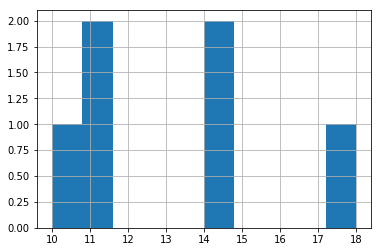

In [17]:
training_data_df[BEST_EPOCH].hist()

In [18]:
training_data_df[TOTAL_DURATION].describe()

count       6.000000
mean     5024.333333
std       124.939452
min      4875.000000
25%      4917.250000
50%      5039.000000
75%      5115.000000
max      5176.000000
Name: Total_Duration(s), dtype: float64

In [19]:
training_data_df.groupby([TRAINING_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Training_Number,,,,,,,,
0,6.0,0.858986,0.002917,0.855135,0.856994,0.859747,0.859988,0.863142


In [20]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,6.0,0.858986,0.002917,0.001191,0.855925,0.862047


In [21]:
rp.summary_cont(training_data_df.groupby(MODEL))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Model,,,,,,
datalawyer,6,0.858986,0.002917,0.001191,0.856652,0.86132


In [22]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
word2vec-lc-5B,6,0.858986,0.002917,0.001191,0.856652,0.86132


In [23]:
rp.summary_cont(training_data_df.groupby([MODEL,EMBEDDING]))[TEST_F1_MEASURE]

,,N,Mean,SD,SE,95% Conf.,Interval
Model,Embedding,,,,,,
datalawyer,word2vec-lc-5B,6,0.858986,0.002917,0.001191,0.856652,0.86132


In [24]:
print(TEST_F1_MEASURE, MODEL, EMBEDDING, BATCH_SIZE, ELMO_DROPOUT)

Test_F1_Measure Model Embedding Batch_Size ELMo_Dropout


In [25]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [26]:
print_anova(EMBEDDING)

Overall model F( 0, 5) =  nan, p =  nan
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 27 May 2019   Prob (F-statistic):                nan
Time:                        00:05:52   Log-Likelihood:                 27.057
No. Observations:                   6   AIC:                            -52.11
Df Residuals:                       5   BIC:                            -52.32
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

/home/user/anaconda3/envs/allennlp/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1554: RuntimeWarning: invalid value encountered in double_scalars
  return self.ess/self.df_model
/home/user/anaconda3/envs/allennlp/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


ValueError: must have at least one row in constraint matrix